In [2]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from definitions import ROOT_DIR

In [3]:
import pandas as pd
import numpy as np

In [4]:
from src.features.multi_omics import MultiOmicsData

lusc_data = MultiOmicsData(cancer_type="LUSC", 
                           folder_path=ROOT_DIR+"/data/tcga-assembler/LUSC/", 
                           modalities=["GE", "MIR"])

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


('DRUGS', (357, 4))
('PATIENTS', (504, 5))
('MIR', (380, 1870))
('GE', (552, 20472))


In [5]:
centroids = pd.read_csv(ROOT_DIR+"/data/external/wilkerson.scc/predictor.centroids.csv")
centroids.columns = ["genes", "primitive", "classical", "secretory", "basal"]
centroids = centroids[centroids["genes"].isin(lusc_data.GE.get_genes_list())]
centroid_genes = centroids["genes"]

In [6]:
centroids.index = centroids.genes
centroids.drop(['genes'], axis=1, inplace=True)
centroids = centroids.T
centroids

genes,MYL6B,PODXL2,HSF2,TTLL4,MARCKSL1,MDK,CHKA,TRIM28,STOM,CASP1,...,ALDH1A3,DSE,MMP10,VDR,CAPZB,FNBP1,ENPP4,SH2B3,DOCK10,SDC1
primitive,0.539568,0.852272,0.293831,0.679557,1.015985,1.001421,0.513166,0.569403,-0.737997,-0.775559,...,-0.231312,-0.521502,-0.862938,-0.421701,-0.015213,-0.016889,0.232617,-0.178687,-0.121821,-0.764157
classical,-0.139755,-0.019997,0.060404,-0.089302,-0.306555,-0.019797,-0.150269,0.021242,-0.065057,-0.187048,...,-0.485903,-0.462036,-0.649346,-0.259443,-0.216407,-0.103185,-0.276022,-0.169656,-0.137791,0.337130
secretory,-0.084411,-0.104802,-0.131566,-0.044189,0.012595,-0.202898,0.235328,-0.264212,0.297794,0.305713,...,0.325191,0.487990,-0.974158,0.384095,0.180478,0.421356,0.482619,0.533466,0.569353,-0.998660
basal,-0.033551,-0.053003,-0.079130,-0.084657,0.097278,-0.222180,-0.136313,0.011287,0.043434,0.063549,...,0.905489,0.509466,2.926716,0.309637,0.216626,-0.185309,-0.147701,-0.030816,-0.093761,0.419894


# Subsetting the GE data to only genes

In [7]:
lusc_ge = lusc_data.GE.data[centroid_genes]


# Subset the LUSC samples to only tumor samples
lusc_ge = lusc_ge[lusc_ge.index.str.contains("-01A")]

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-np.max(np.abs(centroids.values)), np.max(np.abs(centroids.values))))
# scaler = MinMaxScaler()
# scaler.fit(centroids)

# Classify LUSC patients based on cluster centroids obtained from Wilkenson, et. al

TODO Read paper "The molecular portraits of breast tumors are conserved across microarray platforms" on how to do subtype prediction

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)

In [10]:
kmeans.cluster_centers_ = centroids.values

In [11]:
lusc_subtypes_map = {0: 'Primitive', 1: 'Classical', 2: 'Secretory', 3: 'Basal'}

lusc_subtypes_pred = pd.DataFrame(kmeans.predict(scaler.fit_transform(lusc_ge)), index=lusc_ge.index)
lusc_subtypes_pred.columns = ["subtype"]
lusc_subtypes_pred.replace({"subtype": lusc_subtypes_map}, inplace=True)
lusc_subtypes_pred["subtype"].value_counts(sort=False, normalize=False)

Secretory     40
Primitive     23
Classical    221
Basal        212
Name: subtype, dtype: int64

# Assign predicted subtypes to LUSC patients samples

In [12]:
lusc_subtypes_pred["patient_barcode"] = lusc_subtypes_pred.index.str[:-4]

lusc_data.add_subtypes_to_patients_clinical(dict(zip(lusc_subtypes_pred["patient_barcode"], lusc_subtypes_pred["subtype"])))

In [13]:
X, y = lusc_data.load_data(multi_omics=["GE"], 
#                            target=["ajcc_pathologic_tumor_stage"], 
                           target=["predicted_subtype"], 
                           predicted_subtypes=["Primitive"], 
#                            pathologic_stages=['Stage I', 'Stage II', 'Stage III', 'Stage IV']
                          )
print X["GE"].shape , y.shape

(29, 20472) (29, 1)


# Putative Associations

In [14]:
from src.data.make_dataset import Target_Scan
target_scan = Target_Scan(mirna_list=lusc_data.MIR.get_genes_list(), gene_symbols=lusc_data.GE.get_genes_list())

# Load miRanda putative miRNA-target associations
miRanda_df = pd.read_table(os.path.join(ROOT_DIR, 'data/external/miRanda_hg19_predictions_S_C_aug2010.txt'), delimiter='\t')
miRanda_df = miRanda_df[['mirna_name',  'gene_symbol']]

miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.lower()
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("*", "")
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("-3p.*|-5p.*", "")
print miRanda_df.shape

miRanda_df.columns = ["MiRBase ID", "Gene Symbol"]
miRanda_df = miRanda_df[miRanda_df['MiRBase ID'].isin(lusc_data.MIR.get_genes_list()) & miRanda_df['Gene Symbol'].isin(lusc_data.GE.get_genes_list())].dropna().drop_duplicates()
print miRanda_df.shape

# Union TargetScan and MiRanDa miRNA-target associations
targetScan_df = target_scan.get_miRNA_target_interaction_context()
putative_assocs = pd.concat([targetScan_df, miRanda_df]).dropna().drop_duplicates()
print putative_assocs.shape

(1097064, 2)
(532659, 2)
(603489, 2)


# Run MDSN dysregulation analyses

In [ ]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import warnings
warnings.filterwarnings('ignore')

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Secretory"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Classical"])
network_subtype_sc = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_sc.fit(tag="Secretory-Classical", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=putative_assocs)

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Classical"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Basal"])
network_subtype_cb = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_cb.fit(tag="Classical-Basal", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=putative_assocs)

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Secretory"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Basal"])
network_subtype_sb = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_sb.fit(tag="Secretory-Basal", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=putative_assocs)

network_norm_tumor = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], pathologic_stages=["Normal"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], pathologic_stages=["Stage I", "Stage II", "Stage III", "Stage IV"],
                          )
print network_norm_tumor.fit(tag="Secretory-Basal", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=putative_assocs)

n_A 37
n_B 333
30953


In [8]:
# Write graph to file
# import networkx as nx

# nx.write_gml(network_subtype_ab.B, path="./network_subtype_ab_-2.gml")
# nx.write_gml(network_subtype_pb.B, path="./network_subtype_pb_-2.gml")
# nx.write_gml(network_subtype_ap.B, path="./network_subtype_ap_-2.gml")

# nx.write_gml(network_subtype_ac.B, path="./network_subtype_ac_-2.gml")
# nx.write_gml(network_subtype_pc.B, path="./network_subtype_pc_-2.gml")
# nx.write_gml(network_subtype_bc.B, path="./network_subtype_bc_-2.gml")

# Combine subtypes dysregulation networks into one

In [17]:
import networkx as nx

def relabel_mapping(node):
    # HACK: This function is used to relabel target nodes in the miRNA-target bipartite graph such that target nodes
    # in each distinct bipartite graphs have different names
    if "hsa-" in node:
        return node
    else:
        return node+"_"+str(np.random.randint(1000)) # a random number, so each run gives a "probably" different relabeling
    
nx.relabel_nodes(network_subtype_sc.B, relabel_mapping, copy=False)
nx.relabel_nodes(network_subtype_cb.B, relabel_mapping, copy=False)
nx.relabel_nodes(network_subtype_sb.B, relabel_mapping, copy=False)

In [18]:
network_subtypes = nx.compose_all([network_subtype_sc.B, network_subtype_cb.B, network_subtype_sb.B])

network_subtypes_combined = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
network_subtypes_combined.B = network_subtypes

# sorted(network_subtypes.nodes())

In [19]:
print len(network_subtype_sc.B.edges())
print len(network_subtype_cb.B.edges())
print len(network_subtype_sb.B.edges())
print len(network_norm_tumor.B.edges())
print len(network_subtypes_combined.B.edges())

21307
14154
17712
30953
53152


# Bipartite Graph Analysis

In [20]:
import networkx as nx
from networkx.algorithms import bipartite
import copy

# g = network_subtypes.to_undirected()
g = copy.deepcopy(network_subtypes_combined.B.to_undirected())
g.remove_nodes_from(list(nx.isolates(g)))


miRNAs_nodes = set(n for n, d in g.nodes(data=True) if d['bipartite'] == 0)
targets_nodes = set(g) - miRNAs_nodes
print 'mirnas', len(miRNAs_nodes)
print 'targets', len(targets_nodes)
print 'edges',len(g.edges())

mirnas 254
targets 23726
edges 53152


In [21]:
import scipy
import scipy.sparse as sparse

adj = bipartite.biadjacency_matrix(g, row_order=miRNAs_nodes, column_order=targets_nodes)
print adj.shape
cosine_adj = 1-scipy.spatial.distance.pdist(adj.toarray(), "cosine")

(254, 23726)


## Testing approximate scale-free topology criterion by plotting log10(P(k)) v.s. log10(k). A straight line indicates scale-free topology

In [22]:
import matplotlib.pyplot as plt
k_power=1
# cosine_adj_hist_dist = scipy.stats.gaussian_kde(np.power(cosine_adj, k_power))
cosine_adj_hist = np.histogram(np.power(cosine_adj, k_power), bins=500)
cosine_adj_hist_dist = scipy.stats.rv_histogram(cosine_adj_hist)

plt.scatter(x=np.log10(np.power(cosine_adj, k_power)),
            y=np.log10(cosine_adj_hist_dist.pdf(np.power(cosine_adj, k_power))), 
            marker='.')
plt.xlabel("np.log10(k)")
plt.ylabel("np.log10(P(k))")
plt.show()

<Figure size 640x480 with 1 Axes>

In [23]:
k_power = 1
c = np.log10(np.power(cosine_adj, k_power))
d = np.log10(cosine_adj_hist_dist.pdf(np.power(cosine_adj, k_power)))

d_ = d[np.where(c != -np.inf)]
d_ = d_[np.where(d_ != -np.inf)]
c_ = c[np.where(d != -np.inf)]
c_ = c_[np.where(c_ != -np.inf)]

print np.count_nonzero(~np.isnan(d_))
print np.max(c_), np.min(c_), len(c_)
print np.max(d_), np.min(d_), len(d_)
print np.power(scipy.stats.pearsonr(c_, d_)[0], 2)

15081
-0.16677151586966707 -2.7463578502393746 15081
2.427016643277653 -1.8047841487802465 15081
0.7627141148681206


## Graph Distribution of the Cosine Similarity Connections

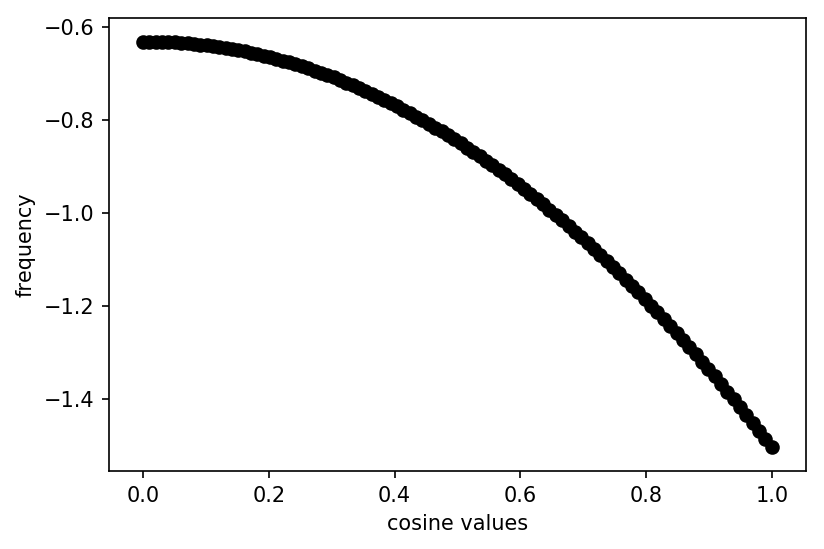

In [24]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(np.array(cosine_adj)[:,np.newaxis])
x_data = np.linspace(0., 1., 100)[:, np.newaxis]
kde_samples = kde.score_samples(x_data)

plt.figure(dpi=150)
plt.scatter(x=x_data, y=kde_samples, c="black")
# plt.ylim(0, 200)
# plt.xlim(0, 0.2)
plt.ylabel("frequency")
plt.xlabel("cosine values")
plt.show()

## Hard-thresholding

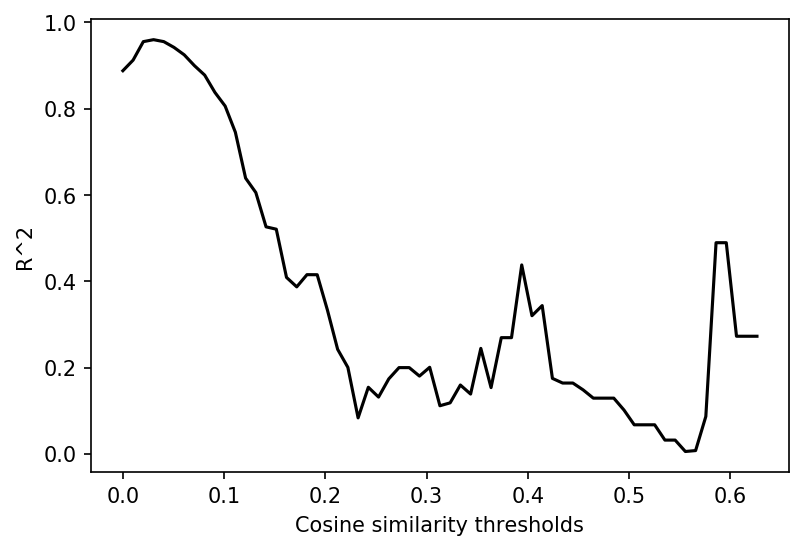

In [25]:
R_thresholds = np.linspace(0,1,100)
r_sqrs = []
k_power = 1
    
for threshold in R_thresholds:
    samples = np.power(cosine_adj, k_power)
    samples[(samples < threshold)] = 0
#     samples = samples[(samples > threshold)]

    cosine_adj_hist = np.histogram(samples, bins=100)
    cosine_adj_hist_dist = scipy.stats.rv_histogram(cosine_adj_hist)
    c = np.log10(samples)
    d = np.log10(cosine_adj_hist_dist.pdf(samples))
    
    d_ = d[np.where(c != -np.inf)]
    d_ = d_[np.where(d_ != -np.inf)]
    c_ = c[np.where(d != -np.inf)]
    c_ = c_[np.where(c_ != -np.inf)]
    
    r_sqr = scipy.stats.pearsonr(c_, d_)
    r_sqr = r_sqr[0]*r_sqr[0]
    r_sqrs.append(r_sqr)

# print B[np.argmax(r_sqrs)]
plt.figure(dpi=150)
# plt.scatter(x=R_thresholds, y=r_sqrs, marker='.', c="black")
plt.plot(R_thresholds, r_sqrs, c="black")
plt.ylabel("R^2")
plt.xlabel("Cosine similarity thresholds")
plt.show()

## Soft-thresholding

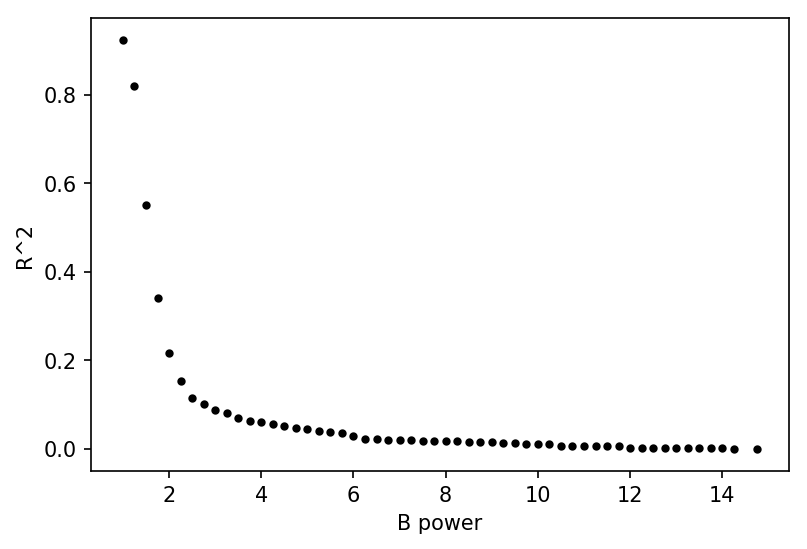

In [26]:
B = np.arange(1,15,0.25)
r_sqrs = []

for b in B:
    k_power = b
    samples = np.power(cosine_adj, k_power)
    
    cosine_adj_hist = np.histogram(samples, bins=200)
    cosine_adj_hist_dist = scipy.stats.rv_histogram(cosine_adj_hist)
    c = np.log10(samples)
    d = np.log10(cosine_adj_hist_dist.pdf(samples))

    d_ = d[np.where(c != -np.inf)]
    d_ = d_[np.where(d_ != -np.inf)]
    c_ = c[np.where(d != -np.inf)]
    c_ = c_[np.where(c_ != -np.inf)]
    
    r_sqr = scipy.stats.pearsonr(c_, d_)
    r_sqr = r_sqr[0]*r_sqr[0]
    r_sqrs.append(r_sqr)

# print B[np.argmax(r_sqrs)]
plt.figure(dpi=150)
plt.scatter(x=B, y=r_sqrs, marker='.', c="black")
plt.ylabel("R^2")
plt.xlabel("B power")
plt.show()

In [52]:
# threshold = np.percentile(np.power(cosine_adj,3), 60)
threshold = 0.4
print threshold

0.4


In [53]:
k_power = 1
cosine_adj_sq = scipy.spatial.distance.squareform(np.power(cosine_adj, k_power))
cosine_adj_sq[np.where(cosine_adj_sq < threshold)] = 0
m = nx.from_numpy_matrix(cosine_adj_sq, create_using=nx.Graph())
m = nx.relabel_nodes(m, {index: miRNA for (index, miRNA) in enumerate(miRNAs_nodes)})
print "edges", len(m.edges())

edges 27


In [54]:
print len(set(m))
m.remove_nodes_from(list(nx.isolates(m)))
print "non-isolate nodes", len(set(m))
layout = nx.spring_layout(m, 
                          weight='weight',
                          k=10.1/np.sqrt(g.number_of_nodes()),
                          iterations=50)

254
non-isolate nodes 28


In [55]:
from bokeh.models import ColumnDataSource

nodes, nodes_coordinates = zip(*sorted(layout.items()))
nodes_xs, nodes_ys = list(zip(*nodes_coordinates))
nodes_source = ColumnDataSource(dict(x=nodes_xs, y=nodes_ys,
                                     name=[n[4:] for n in nodes]))

In [56]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.layouts import widgetbox
from bokeh.models import HoverTool, LabelSet
from bokeh.models import Toggle, BoxAnnotation, CustomJS

hover = HoverTool(tooltips=[('name', '@name')])
plot = figure(plot_width=875, plot_height=700,
              tools=['tap', hover, 'box_zoom', 'reset', 'pan'])
r_circles = plot.circle('x', 'y', source=nodes_source, size=5,
                        color='blue', level = 'overlay')
hover.renderers.append(r_circles)

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None

# layout = bl([p], [toggle])
# show(layout)

In [57]:
def get_edges_specs(_network, _layout):
    d = {'xs': [], 'ys': [], 'alphas': [], 'name': []}
    weights = [data['weight'] for u, v, data in _network.edges(data=True)]
    calc_alpha = lambda h: 0.1 + 0.9*h

    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
        d['name'].append(str(u)+'<=>'+str(v))
    return d

lines_source = ColumnDataSource(get_edges_specs(m, layout))

r_lines = plot.multi_line('xs', 'ys', line_width=1.5,
                          alpha='alphas', color='black',
                          source=lines_source)
r_lines = plot.multi_line('xs', 'ys', line_width=1.5,
                          alpha='alphas', color='black',
                          source=lines_source)
# show(plot)

In [58]:
centrality =\
    nx.algorithms.centrality.betweenness_centrality(m)
# first element are nodes again
_, nodes_centrality = zip(*sorted(centrality.items()))
max_centrality = max(nodes_centrality)
nodes_source.add([7 + 10 * t / max_centrality
                  for t in nodes_centrality],
                 'centrality')

import community # python-louvain
partition = community.best_partition(m, weight="weight")
p_, nodes_community = zip(*sorted(partition.items()))
nodes_source.add(nodes_community, 'community')
community_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628', '#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
nodes_source.add([community_colors[t % len(community_colors)]
                  for t in nodes_community],
                 'community_color')

print np.bincount(partition.values()), len(np.unique(partition.values()))

[2 4 2 8 2 2 2 2 2 2] 10


In [59]:
from bokeh.io import output_notebook, show
output_notebook()

r_circles.glyph.size = 'centrality'
r_circles.glyph.fill_color = 'community_color'

proc_labels = LabelSet(x='x', y='y', text="name", 
                       text_font_size="8pt", text_color="navy",
                       source=nodes_source, text_align='center')

plot.add_layout(proc_labels)

code = '''\
if toggle.active
    labels.visible = true
    console.log 'enabling box'
else
    labels.visible = false
    console.log 'disabling box'
'''
callback = CustomJS.from_coffeescript(code=code, args={})
toggle = Toggle(label="Toggle miRNA label", button_type="success", callback=callback)
callback.args = {'toggle': toggle, 'labels': proc_labels}

show(plot)
show(toggle)

Loading BokehJS ...

## Multi-clusters analysis with rand index

In [38]:
tn_partition = network_norm_tumor.get_miRNA_community_assgn(threshold=0.01, power=1)

sc_partition = network_subtype_sc.get_miRNA_community_assgn(threshold=0.01, power=1)
cb_partition = network_subtype_cb.get_miRNA_community_assgn(threshold=0.01, power=1)
sb_partition = network_subtype_sb.get_miRNA_community_assgn(threshold=0.01, power=1)

com_partition = network_subtypes_combined.get_miRNA_community_assgn(threshold=0.01, power=1)

mirnas 240
targets 9728
edges 30953
edges after threshold: 12118
mirnas 247
targets 8649
edges 21307
edges after threshold: 8612
mirnas 250
targets 7109
edges 14154
edges after threshold: 7336
mirnas 247
targets 7987
edges 17712
edges after threshold: 7091
mirnas 254
targets 23726
edges 53152
edges after threshold: 8724


In [41]:
from sklearn import metrics
from src.models.miRNA_target_network import miRNATargetNetwork

partitions = {"Secretory vs Classical":miRNATargetNetwork.group_assg_list(sc_partition, lusc_data.MIR.get_genes_list()),
             "Classical vs Basal":miRNATargetNetwork.group_assg_list(cb_partition, lusc_data.MIR.get_genes_list()),
             "Secretory vs Basal":miRNATargetNetwork.group_assg_list(sb_partition, lusc_data.MIR.get_genes_list()),
             "combined":miRNATargetNetwork.group_assg_list(com_partition, lusc_data.MIR.get_genes_list()),
             "tumor vs normal":miRNATargetNetwork.group_assg_list(tn_partition, lusc_data.MIR.get_genes_list()),
             "miRNA family":target_scan.get_miRNA_family_group_assg()}
# keys = partitions.keys()
keys = ['Secretory vs Classical', 'Classical vs Basal', 'Secretory vs Basal',
        "combined", 'tumor vs normal', 'miRNA family']

m = []
for p in keys:
    n = []
    for q in keys:
        n.append(miRNATargetNetwork.cluster_similarity(partitions[p], partitions[q], metric="nmi"))
    m.append(n)
#         if p < q:
#             print p,"vs", q,"\t", miRNATargetNetwork.cluster_similarity(partitions[p], partitions[q], metric="rand")
print m
m = np.asarray(m)

[[1.0, 0.20830336183638057, 0.40470674652522154, 0.3378349085281755, 0.17908038808211152, 0.5338895396011247], [0.20830336183638057, 1.0, 0.2440418491746635, 0.3411845575729617, 0.2492620271422415, 0.5006857430140123], [0.40470674652522154, 0.24404184917466354, 1.0, 0.45756743703177366, 0.19744004254314682, 0.5558842985000889], [0.3378349085281755, 0.3411845575729617, 0.45756743703177377, 1.0, 0.24078717307453115, 0.5346783478835199], [0.17908038808211155, 0.24926202714224144, 0.19744004254314684, 0.24078717307453115, 1.0, 0.5240372408504572], [0.5338895396011247, 0.5006857430140121, 0.5558842985000889, 0.5346783478835199, 0.5240372408504573, 1.0]]


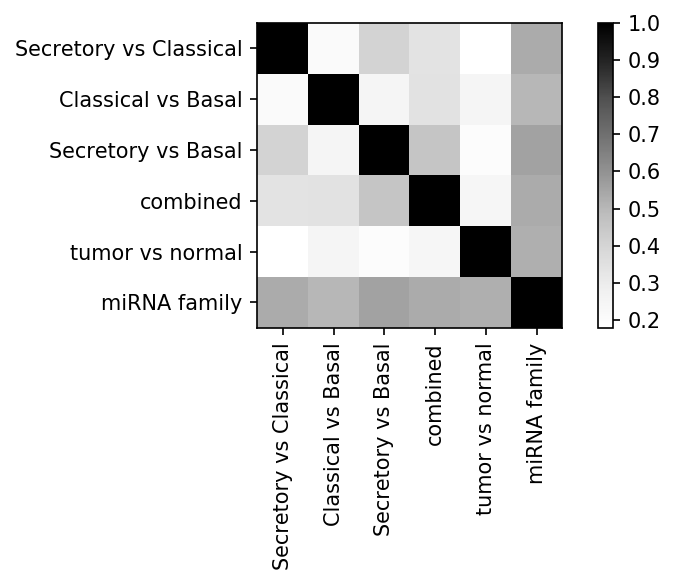

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='miRNA clusters similarity between different subtype dysregulation analyses',
                          cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()

plt.figure(dpi=150)
plot_confusion_matrix(m, keys)
plt.show()

# 
# 
# 
# Prepare samples for Classification task

In [1]:
from sklearn.model_selection import train_test_split


# X_normal, _ = lusc_data.load_data(multi_omics=["MIR"], target=["ajcc_pathologic_tumor_stage"], 
#                                   pathologic_stages=["Normal"])
X, y = lusc_data.load_data(multi_omics=["MIR"], target=["ajcc_pathologic_tumor_stage"])
#                            samples_barcode=X_normal["MIR"].index)
X = X["MIR"]
stage_label_mapping = {'Normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1}
y["ajcc_pathologic_tumor_stage"] = y["ajcc_pathologic_tumor_stage"].replace(stage_label_mapping)


X_multi, y_multi = lusc_data.load_data(multi_omics=["MIR"], target=["ajcc_pathologic_tumor_stage"])
X_multi = X_multi["MIR"]
stage_label_mapping = {'Normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4}
y_multi["ajcc_pathologic_tumor_stage"] = y_multi["ajcc_pathologic_tumor_stage"].replace(stage_label_mapping)


X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = \
    train_test_split(X_multi, y_multi, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y_multi)

print "X", X.shape
print "y", y.shape
print "X_multi", X_multi.shape
print "y_multi", y_multi.shape
print y["ajcc_pathologic_tumor_stage"].value_counts()
print y_multi["ajcc_pathologic_tumor_stage"].value_counts()

NameError: name 'lusc_data' is not defined

In [ ]:
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 1000,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5

X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])
X_multi_train = np.asfortranarray(X_multi_train, dtype=myfloat)
Y_multi_train = np.asfortranarray(Y_multi_train, dtype=myfloat)
Y_multi_train = np.reshape(Y_multi_train, [Y_multi_train.shape[0], 1])

# L1 Lasso
l1_lasso_param = param.copy()
l1_lasso_param['loss'] = 'weighted-logistic'
l1_lasso_param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=l1_lasso_param)

# Group Lasso L2
# group_l2_param = param.copy()
# group_l2_param['loss'] = 'weighted-logistic'
# group_l2_param['regul'] = 'group-lasso-l2'
# group_l2 = SPAMSClassifier()
# group_l2.fit(X_train, Y_train, groups=network.get_miRNA_cluster_assgn(), params=group_l2_param)

# Elastic Net
elastic_net_param = param.copy()
elastic_net_param['loss'] = 'weighted-logistic'
elastic_net_param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=elastic_net_param)

# Sparse Group Lasso
sparse_group_l2_param = param.copy()
sparse_group_l2_param['loss'] = 'logistic'
sparse_group_l2_param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2_param['lambda1'] = 0.2
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=partitions["combined"], params=sparse_group_l2_param)

# Multi Logistic
multi_task_l1l2_param = param.copy()
multi_task_l1l2_param['loss'] = 'multi-logistic'
multi_task_l1l2_param['regul'] = 'l1l2'
multi_task_l1l2_param['max_it'] = 200
multi_task_l1l2_param['lambda1'] = 0.5
multi_task_l1l2 = SPAMSClassifier()
multi_task_l1l2.fit(X_multi_train, Y_multi_train, groups=None, params=multi_task_l1l2_param)